In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import pyrex
#import pyrex.custom.ara as ara
from pyrex.internal_functions import normalize
import os
import sys
import seaborn as sns
import polReco_util as util
import scipy

import ROOT
from ROOT import TCanvas, TGraph
from ROOT import gROOT
from ROOT import gInterpreter, gSystem
from ROOT import TChain, TSelector, TTree
from scipy.stats import norm
from scipy.stats import rayleigh


gInterpreter.ProcessLine('#include "/cvmfs/ara.opensciencegrid.org/trunk/centos7/source/libRootFftwWrapper/include/FFTtools.h"')

gSystem.Load('/users/PAS0654/jflaherty13/source/AraRoot/AraRoot_build/lib/libAraEvent.so')
gSystem.Load("/cvmfs/ara.opensciencegrid.org/trunk/centos7/source/libRootFftwWrapper/build/libRootFftwWrapper.so")

gInterpreter.ProcessLine('#include "/users/PAS0654/jflaherty13/source/AraSim/Position.h"')
gInterpreter.ProcessLine('#include "/users/PAS0654/jflaherty13/source/AraSim/Report.h"')
gInterpreter.ProcessLine('#include "/users/PAS0654/jflaherty13/source/AraSim/Detector.h"')
gInterpreter.ProcessLine('#include "/users/PAS0654/jflaherty13/source/AraSim/Settings.h"')
gInterpreter.ProcessLine('#include "/users/PAS0654/jflaherty13/source/AraSim/IceModel.h"')
gInterpreter.ProcessLine('#include "/users/PAS0654/jflaherty13/source/AraSim/EarthModel.h"')
gInterpreter.ProcessLine('#include "/users/PAS0654/jflaherty13/source/AraSim/Event.h"')
gInterpreter.ProcessLine('#include "/users/PAS0654/jflaherty13/source/AraSim/Spectra.h"')

# mpl.use('agg') 
mpl.rcParams['text.usetex'] = True
#mpl.rcParams['text.latex.preamble'] = [r'\usepackage{amsmath}'] #for \text command
#mpl.rcParams['text.latex.unicode'] = True
mpl.rcParams['mathtext.rm'] = 'Times New Roman'
mpl.rcParams['mathtext.it'] = 'Times New Roman:italic'
mpl.rcParams['mathtext.bf'] = 'Times New Roman:bold'

mpl.rc('font', family='serif', size=12)
mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 14
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['ytick.major.size'] = 5

mpl.rcParams['axes.titlesize'] = 18
mpl.rcParams['axes.labelsize'] = 18
mpl.rc('font', size=16)
mpl.rc('axes', titlesize=20)

#current_palette = sns.color_palette('colorblind', 10)
current_palette = sns.color_palette('bright', 10)

/cvmfs/ara.opensciencegrid.org/trunk/RHEL_7_x86_64/root_build/lib/cppyy/__init__.py:72: DeprecationWarning: invalid escape sequence \d
  if re.match('^libcppyy_backend\d_\d$', lib_name):


Welcome to JupyROOT 6.22/06


Warning in <TClassTable::Add>: class FFTtools::AnalyticSignal already in TClassTable
Warning in <TClassTable::Add>: class FFTtools::CompositeSignal already in TClassTable
Warning in <TClassTable::Add>: class FFTtools::BandlimitedSampledSignal already in TClassTable
Warning in <TClassTable::Add>: class FFTtools::ThermalNoise already in TClassTable
Warning in <TClassTable::Add>: class FFTtools::Averager already in TClassTable
Warning in <TClassTable::Add>: class FFTtools::CWT already in TClassTable
Warning in <TClassTable::Add>: class FFTtools::CWT::MotherWavelet already in TClassTable
Warning in <TClassTable::Add>: class FFTtools::CWT::Ricker already in TClassTable
Warning in <TClassTable::Add>: class FFTtools::CWT::Ridger already in TClassTable
Warning in <TClassTable::Add>: class FFTtools::CWT::Morlet already in TClassTable
Warning in <TClassTable::Add>: class FFTtools::DigitalFilter already in TClassTable
Warning in <TClassTable::Add>: class FFTtools::DigitalFilterSeries already in T

In [28]:
station=4
run="6128"
rawFilename = "purifiedSample_run_6128.root"

# station=2
# run="12559"
# rawFilename = "purifiedSample_run_12559.root"

In [36]:
rawInputFile = ROOT.TFile.Open(rawFilename)

file_list = []
file_list.append(rawFilename)

eventTree = TChain("eventTree") #Define chain and tree that needs to be read. "VTree" in this case.
simSettingsTree = TChain("AraTree")
simTree = TChain("AraTree2")

for line in file_list:
    eventTree.AddFile(line)
    simTree.AddFile(line)
    simSettingsTree.AddFile(line)

reportPtr = ROOT.Report()#report pointer
eventPtr = ROOT.Event()
detectorPtr = ROOT.Detector()
interactionPtr = ROOT.Interaction()
stationPtr = ROOT.ARA_station()

usefulEvent = ROOT.UsefulAtriStationEvent()
rawEvent = ROOT.RawAtriStationEvent()

dataLike = False
try:
    eventTree.SetBranchAddress("UsefulAtriStationEvent",ROOT.AddressOf(usefulEvent))
    eventTree.SetBranchAddress("RawAtriStationEvent",ROOT.AddressOf(rawEvent))

    totalRawEvents = eventTree.GetEntries()
    print('total raw events:', totalRawEvents) 
    
except TypeError:
    print("Open as Simulated Data Failed.  Attempting Open as Real Data")
    dataLike = True
    rawInputFile = ROOT.TFile.Open(rawFilename)

    eventTree = rawInputFile.Get("eventTree")

    rawEvent = ROOT.RawAtriStationEvent()
    eventTree.SetBranchAddress("event",ROOT.AddressOf(rawEvent))

    totalRawEvents = eventTree.GetEntries()
    print('total raw events:', totalRawEvents)
    

total raw events: 5


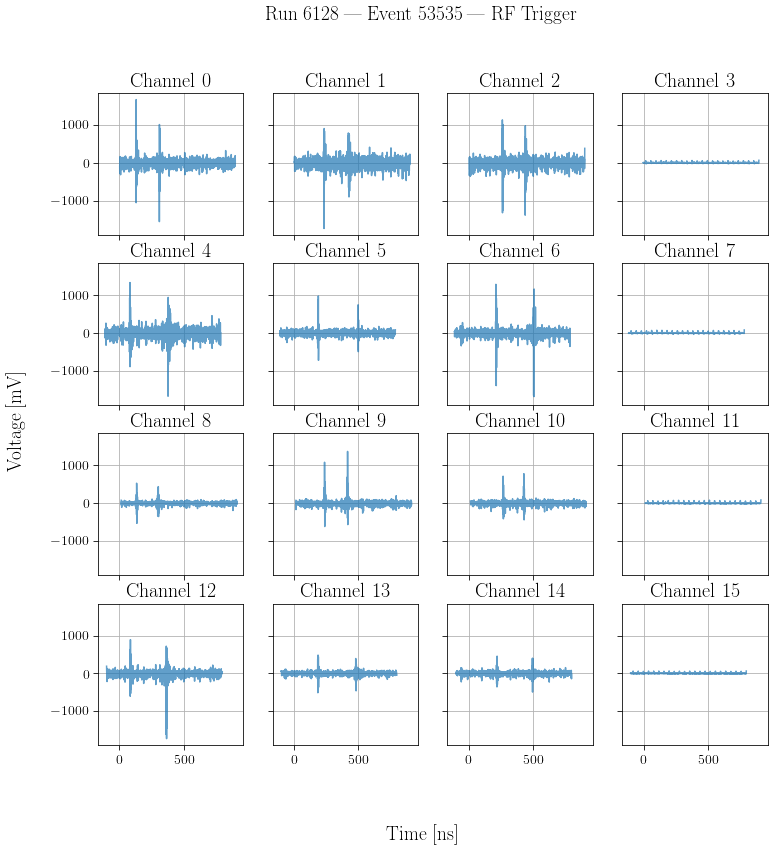

In [37]:
evt = 0
eventTree.GetEntry(evt)
if (dataLike):
    usefulEvent = ROOT.UsefulAtriStationEvent(rawEvent,ROOT.AraCalType.kLatestCalib)
fig, axes = util.plotWaveform(usefulEvent)
if (usefulEvent.isCalpulserEvent()):
    trigType = "Calpulser"
elif (usefulEvent.isSoftwareTrigger()):
    trigType = "Software Trigger"
elif (usefulEvent.isRFTrigger()):
    trigType = "RF Trigger"

try:
    fig.suptitle(" Run " + str(run) + " | Event " + str(usefulEvent.eventNumber) + " | " + trigType)
except AttributeError:
    fig.suptitle("Station " + str(station) + " Run " + run + " | Event " + str(evt) + " | " + trigType)

for ax in axes.flatten():
    ax.grid()


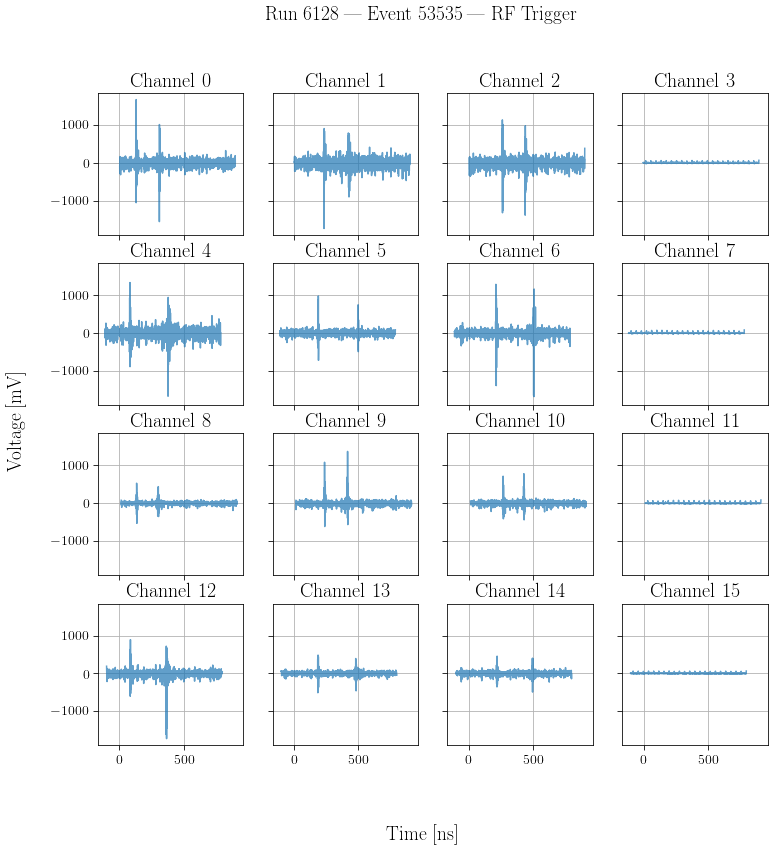

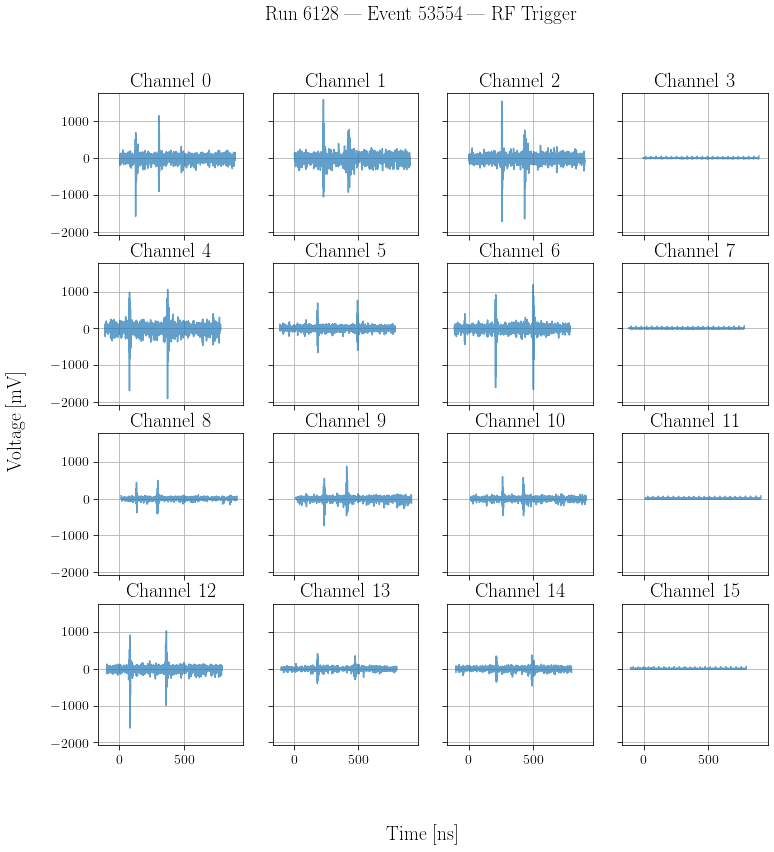

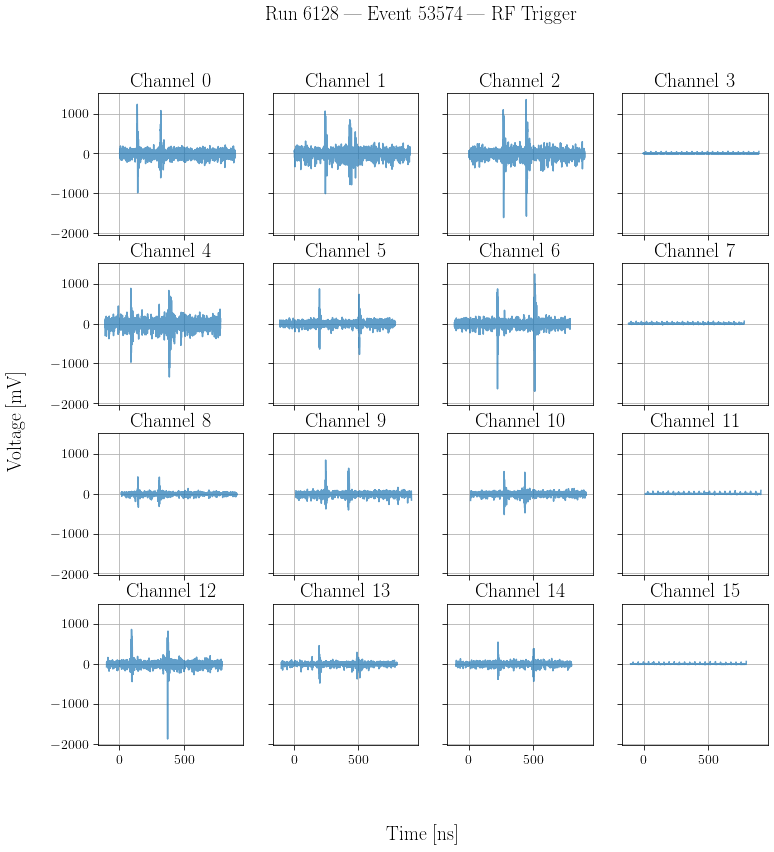

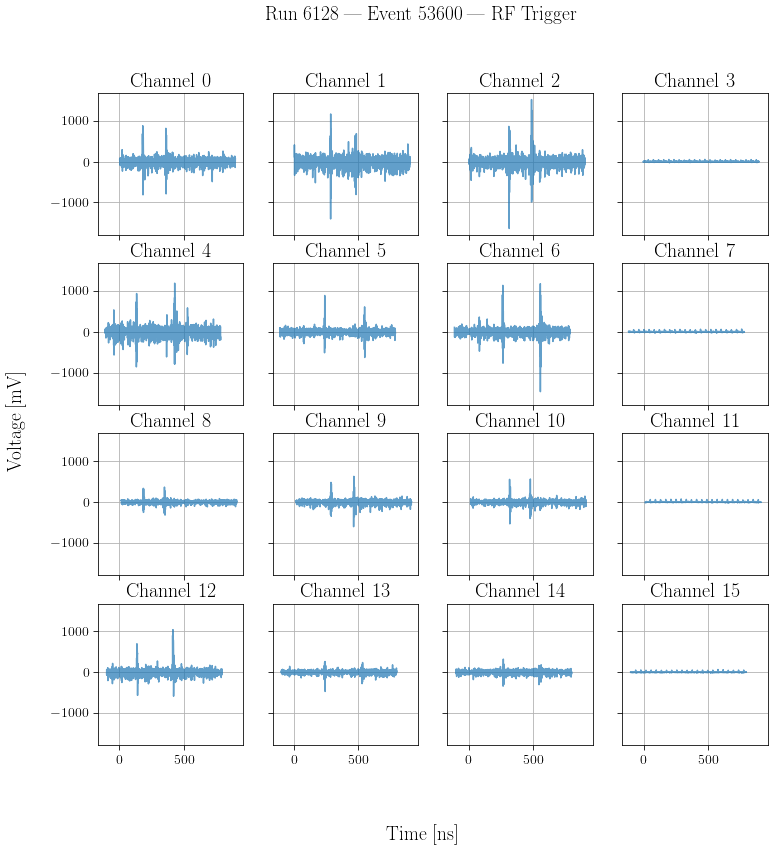

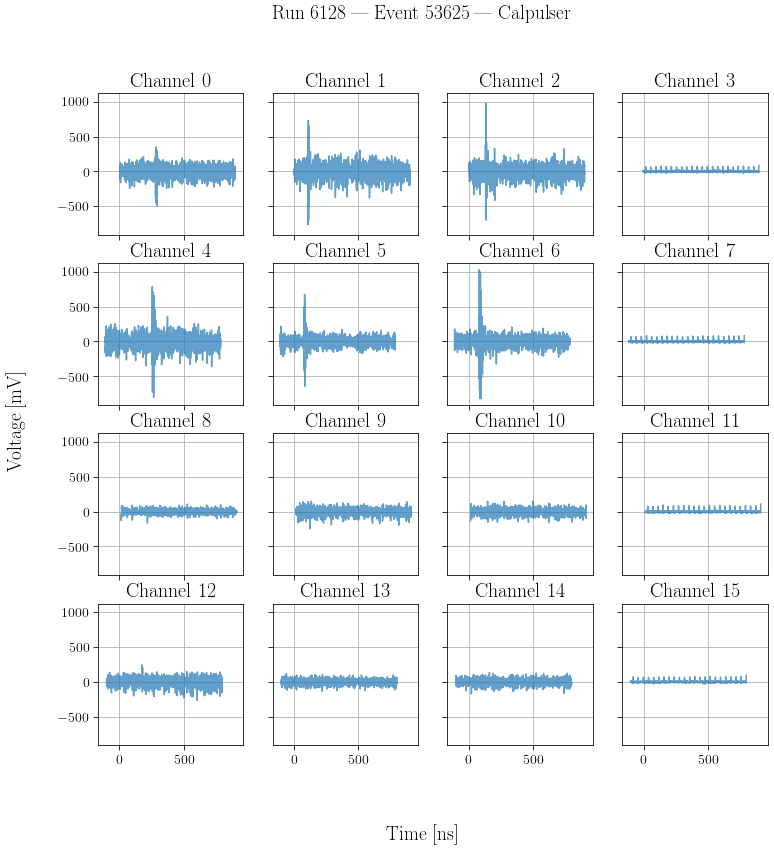

In [38]:
for evt in range(eventTree.GetEntries()):
    eventTree.GetEntry(evt)
    if (dataLike):
        usefulEvent = ROOT.UsefulAtriStationEvent(rawEvent,ROOT.AraCalType.kLatestCalib)
    fig, axes = util.plotWaveform(usefulEvent)
    if (usefulEvent.isCalpulserEvent()):
        trigType = "Calpulser"
    elif (usefulEvent.isSoftwareTrigger()):
        trigType = "Software Trigger"
    elif (usefulEvent.isRFTrigger()):
        trigType = "RF Trigger"

    try:
        fig.suptitle(" Run " + str(run) + " | Event " + str(usefulEvent.eventNumber) + " | " + trigType)
    except AttributeError:
        fig.suptitle("Station " + str(station) + " Run " + run + " | Event " + str(evt) + " | " + trigType)

    for ax in axes.flatten():
        ax.grid()
        
    plt.show()


53600